In [785]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [786]:
#equazioni sempre valide:

#induttanza
L = 53.61e-3
#resistenza induttanza
r_L = 0.852

L:  301.309979206352442e-3
C: 25.897092684151668e-09

#frequenza
f = 400

# forse non è questa? C = 47.3e-10
C = 32.92e-9

w0 = 1/np.sqrt(L*C)
print("critical regime is hit when R = ", 2*np.sqrt(L/C))
#Time - V_0	Amplitude - V_0	Time - V_L	Amplitude - V_L	Time - V_C	Amplitude - V_C	Time - V_R	Amplitude - V_R

critical regime is hit when R =  2552.2486690230185


the standard deviation is: 0.0013156897386523486


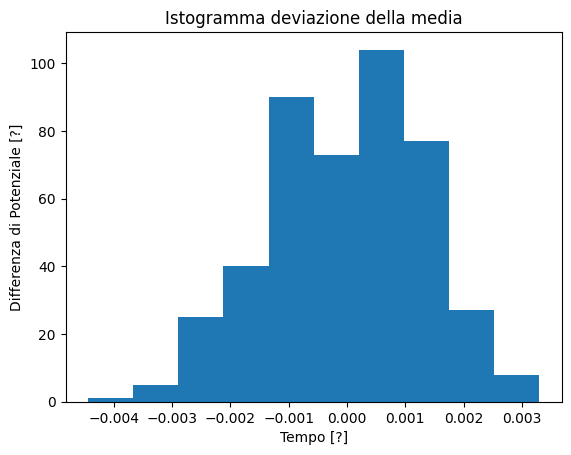

In [787]:
#gaussian fit to evaluate errors
file = "./data/RLC_statico_per_incertezze.txt"

temp = np.loadtxt(file, unpack = True)
data = temp[1]

#removing first values, when it was reaching steady state
data = data[50:]

mean = np.mean(data)
std = np.std(data)

n_bins = 10

fig, axes = plt.subplots()
plt.hist(data-mean, bins = n_bins)

plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Istogramma deviazione della media")

print("the standard deviation is:", std)

In [788]:
#super over damped :)
R = 7413

index: 0.001
parameters:
 [ 1.31863199e+02 -9.14202611e+03  1.49479366e+00  1.37702072e+00
  1.18553851e-04]
covariance matrix:
 [[ 6.14444639e+02  3.64337863e+03  2.45514329e+03 -1.56921812e+05
   1.24591448e+01]
 [ 3.64337863e+03  3.99947121e+04  3.31571713e+04 -2.11900118e+06
   1.68242373e+02]
 [ 2.45514329e+03  3.31571713e+04  8.21823841e+07 -5.25147022e+09
   4.16949806e+05]
 [-1.56921812e+05 -2.11900118e+06 -5.25147022e+09  3.35569961e+11
  -2.66431731e+07]
 [ 1.24591448e+01  1.68242373e+02  4.16949806e+05 -2.66431731e+07
   2.11538205e+03]]
expected value parameter s1:  -16689.117522900055 
value extracted from fit:  131.86319907333893  +/-  24.78799385254773
expected value parameter s2:  -33951.65845173155 
value extracted from fit:  -9142.02611219986  +/-  199.98677992693888


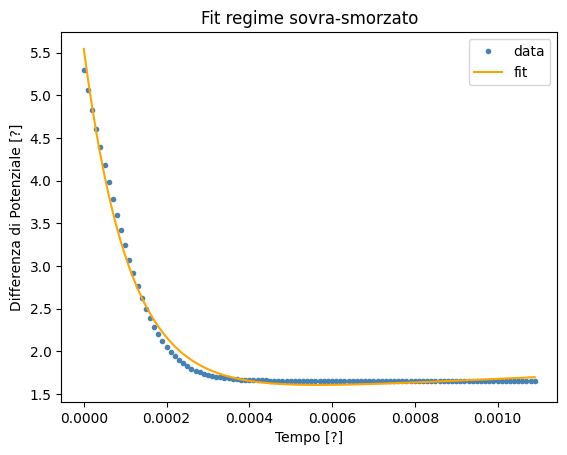

In [789]:
#VC fit over-damped
R = 2714 + r_L

alpha = R/L/2

s1 = np.sqrt(alpha*alpha - w0*w0) - alpha
s2 = -np.sqrt(alpha*alpha - w0*w0) - alpha

def over_damped_fit(x, p1, p2, a1, a2, offset):
    return  a1*np.exp(p1*(x-offset)) + a2*np.exp(p2*(x-offset))

#params
amplitude_guess = 4
offset_guess = 0.00009

P0 = [s1, s2, amplitude_guess, amplitude_guess, offset_guess]

file = "./data/RLC_sovrasmorzato.txt"
temp = np.loadtxt(file, unpack = True)
x = temp[4]
y = temp[5]

print("index:", x[100])

#cropping data for fit:
x = x[130:240] - x[130]
y = y[130:240]

#todo: why does this not change anything from the fit?
popt, pcov = curve_fit(over_damped_fit, x, y, sigma = std, p0 = P0)
#popt, pcov = curve_fit(over_damped_fit, x, y, p0 = P0)

fig, axes = plt.subplots()

plt.plot(x,y, '.', color = 'steelblue', label = "data")
         

plt.plot(x,over_damped_fit(x, *popt), color = 'orange', label = "fit")
plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Fit regime sovra-smorzato")
axes.legend()
print("parameters:\n", popt)
print("covariance matrix:\n",pcov)

#todo: verify it is error
errors = np.sqrt(np.diag(pcov))
print("expected value parameter s1: ", s1, "\nvalue extracted from fit: ", popt[0], " +/- ", errors[0])
print("expected value parameter s2: ", s2, "\nvalue extracted from fit: ", popt[1], " +/- ", errors[1])

In [790]:
#extracting L and C from fit and R:
def from_params_to_RLC(par1, par2, R):
    alpha = -(par1 + par2)/2
    w0 = np.sqrt(((s1 + alpha)**2 -alpha*alpha))
    L = R/alpha/2
    C = 1/(w0*w0)/L
    print("L: ",L)
    print("C:",C)

from_params_to_RLC(popt[0], popt[1], R)

L:  0.30130997920635244
C: 2.5897092684151668e-08


0.00029521608732090935
0.0025
parameters:
 [2.00880700e+04 2.87477798e+03 4.78668765e+00 9.78459735e-02]
covariance matrix:
 [[ 5.35118856e+03 -6.30374649e+02 -1.05656464e+00 -9.68051440e-01]
 [-6.30374649e+02  4.53352301e+03  3.42904555e+00  2.11982162e-01]
 [-1.05656464e+00  3.42904555e+00  5.68277426e-03  3.55017582e-04]
 [-9.68051440e-01  2.11982162e-01  3.55017582e-04  3.22783677e-04]]
expected value parameter beta:  21283.34320869703 
value extracted from fit:  20088.069982580964  +/-  73.15181856566672
expected value parameter alpha:  10660.324566312256 
value extracted from fit:  2874.7779752779597  +/-  67.3314414517802


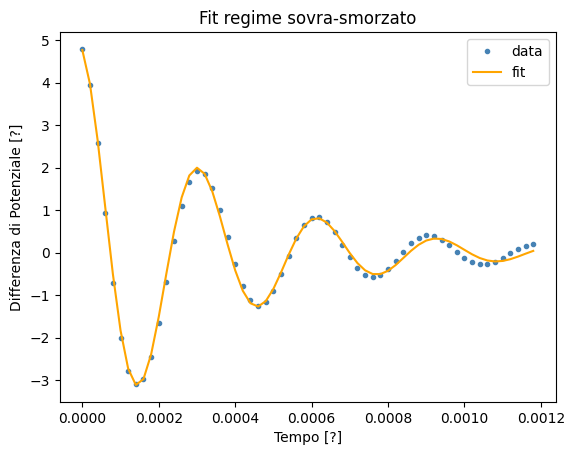

In [791]:
#under damped regime fit of VL
R = 1143
alpha = R/L/2

beta = np.sqrt(w0*w0 - alpha*alpha)

period = 2*np.pi/(beta)
#period of square signal
square_period = 1/(f)
print(period)
#periodo osservato  circa 0.0002
print(square_period)

def under_damped_fit(x,beta,alpha,a,phi):
    return a*np.cos(beta*x+phi)*np.exp(-alpha*x)

#initial parameters
amplitude_guess = 5
phi_guess = 0.01
P0 = [beta,alpha,amplitude_guess,phi_guess]

file = "./data/RLC_sottosmorzato.txt"
temp = np.loadtxt(file, unpack = True)
x = temp[2]
y = temp[3]

#cropping data for fit:
x = x[0:60]
y = y[0:60]

#todo: why does this not change anything from the fit?
popt, pcov = curve_fit(under_damped_fit, x, y, sigma = std, p0 = P0)
#popt, pcov = curve_fit(over_damped_fit, x, y, p0 = P0)

fig, axes = plt.subplots()

plt.plot(x,y, '.', color = 'steelblue', label = "data")
         

plt.plot(x,under_damped_fit(x, *popt), color = 'orange', label = "fit")
plt.xlabel("Tempo [?]")
plt.ylabel("Differenza di Potenziale [?]")
plt.title("Fit regime sovra-smorzato")
axes.legend()
print("parameters:\n", popt)
print("covariance matrix:\n",pcov)

#todo: verify it is error
errors = np.sqrt(np.diag(pcov))
print("expected value parameter beta: ", beta, "\nvalue extracted from fit: ", popt[0], " +/- ", errors[0])
print("expected value parameter alpha: ", alpha, "\nvalue extracted from fit: ", popt[1], " +/- ", errors[1])

In [792]:
#Critical damping 
R = 1237

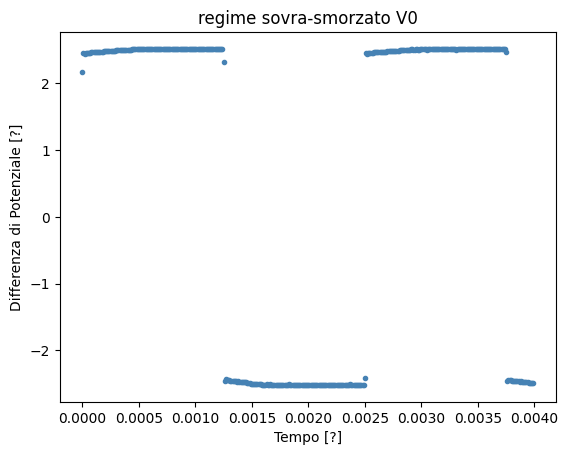

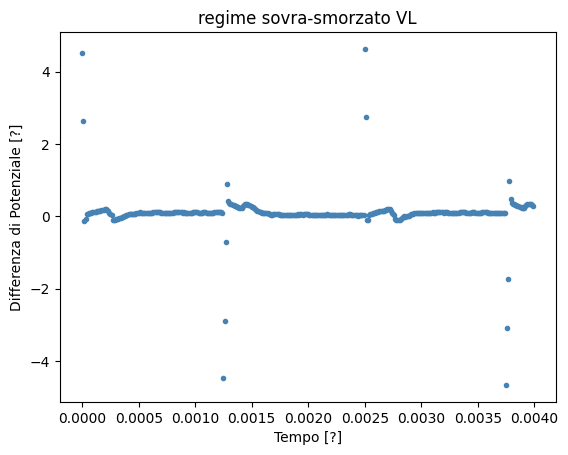

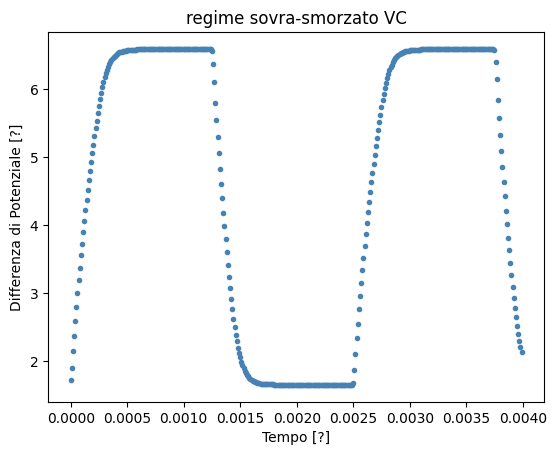

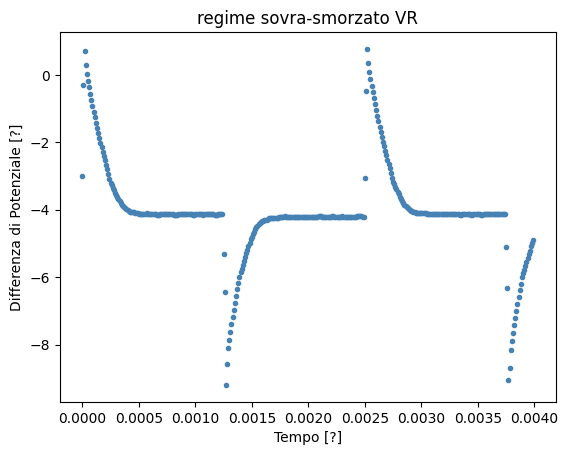

In [793]:
#showing over damped histos
file = "./data/RLC_sovrasmorzato.txt"

plot_names = ["V0", "VL", "VC", "VR"]
data_matrix = np.loadtxt(file, unpack = True)

#plots
for i in range(4):
    x  = data_matrix[2*i]
    y  = data_matrix[2*i+1]

    fig, axes = plt.subplots()
    
    plt.plot(x,y, '.', color = 'steelblue', label = "data")
    plt.xlabel("Tempo [?]")
    plt.ylabel("Differenza di Potenziale [?]")
    plt.title("regime sovra-smorzato " + plot_names[i])

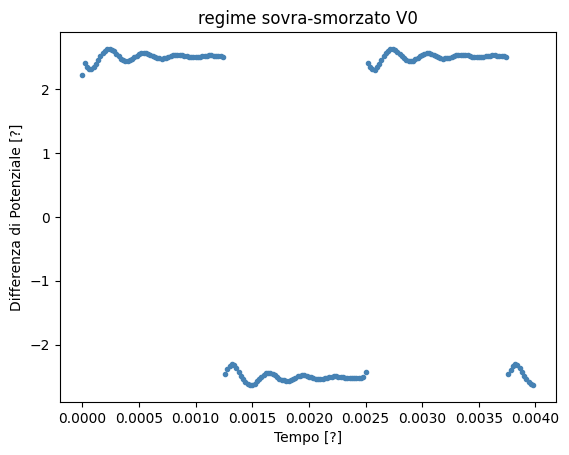

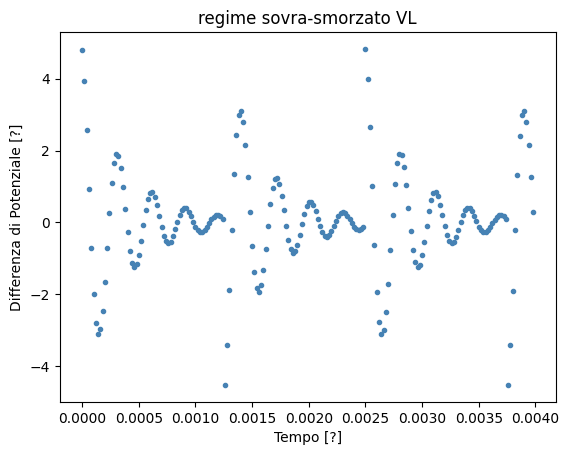

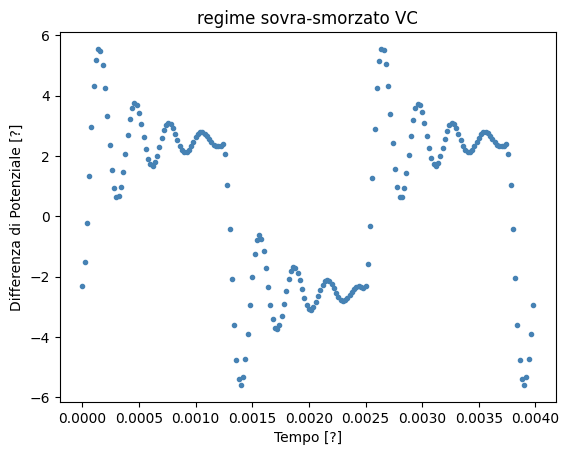

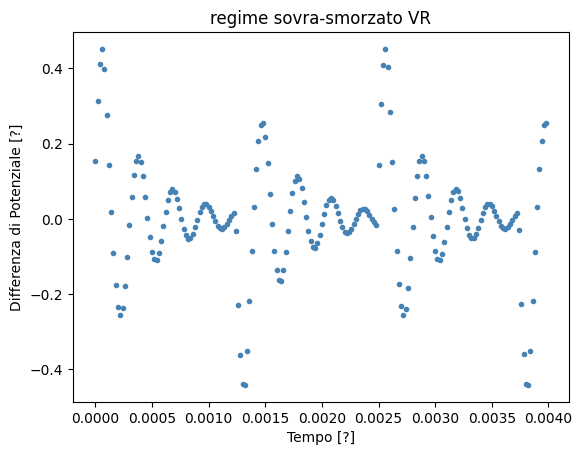

In [794]:
#showing under damped histos
file = "./data/RLC_sottosmorzato.txt"

plot_names = ["V0", "VL", "VC", "VR"]
data_matrix = np.loadtxt(file, unpack = True)

#plots
for i in range(4):
    x  = data_matrix[2*i]
    y  = data_matrix[2*i+1]

    fig, axes = plt.subplots()
    
    plt.plot(x,y, '.', color = 'steelblue', label = "data")
    plt.xlabel("Tempo [?]")
    plt.ylabel("Differenza di Potenziale [?]")
    plt.title("regime sovra-smorzato " + plot_names[i])